# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [34]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [35]:
df_offers = pd.read_excel("./WineKMC.xls", sheet_name=0)

### 1b. Explore the data

In [36]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [37]:
df_transactions = pd.read_excel("./WineKMC.xls", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [38]:
#your turn

df_merged = pd.merge(df_transactions, df_offers)

# We now want to make a pivot table
df_pivot = df_merged.pivot(index='customer_name', columns='offer_id', values='n').fillna(0)
df_pivot.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
Smaller SS would indicate better clusterings due to it being an indicator that the centroid better represents the cluster as a whole. Smaller SS indicate tighter clustersl
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
<p><p>It's pretty arbitrary, and I think there are a couple options here (4 and 8). But with these, I like to err on the side of too few clusters to help generalization and avoid overfitting.
</ul>
</div>

Text(0, 0.5, 'Sum of Squares')

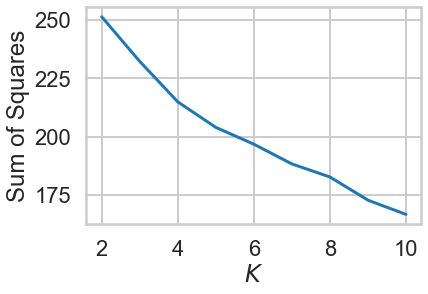

In [39]:
# your turn
import sklearn.cluster
import numpy as np

# Make an empty list
ss = []

# Make an empty dictionary called assignments 
assignments = {}

# Cast your table 'df_pivot' as a matrix with to_numpy(), and store it in a variable X 
X = df_pivot.to_numpy()

# Make a variable called Krange, and assign it a list of range(2, 11)
Krange  = list(range(2, 11))

# We now want to iterate through this list to construct a plot showing SS for each K. Name the iterator variable K 
for K in Krange:
    # Make a variable called model, and assign it the result of calling sklearn.cluster.KMeans, with n_clusters = K 
    model = sklearn.cluster.KMeans(n_clusters=K)
    assigned_cluster = model.fit_predict(X)
    centers = model.cluster_centers_
    ss.append(np.sum((X - centers[assigned_cluster]) ** 2))
    assignments[str(K)] = assigned_cluster
    
# Call plot() on plt with parameters Krange and ss
plt.plot(Krange, ss)

# Let's label the plot 
plt.xlabel("$K$")
plt.ylabel("Sum of Squares")

# Can you see what we're doing here? 

4


([<matplotlib.axis.XTick at 0x20e0719af70>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

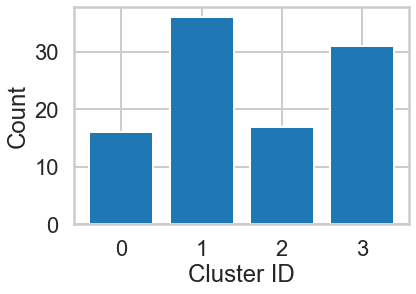

In [40]:
# What is the best K? Fill in the assignment below appropriately
best_K = 4
assignments_best_K = assignments[str(best_K)]
counts = np.bincount(assignments_best_K)
print(len(counts))

# Call bar() on plt, with parameters range(best_K), counts, and align = 'center'
plt.bar(range(best_K), counts, align='center')

# Label the axes 
plt.xlabel("Cluster ID")
plt.ylabel("Count")
plt.xticks(range(best_K))

#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

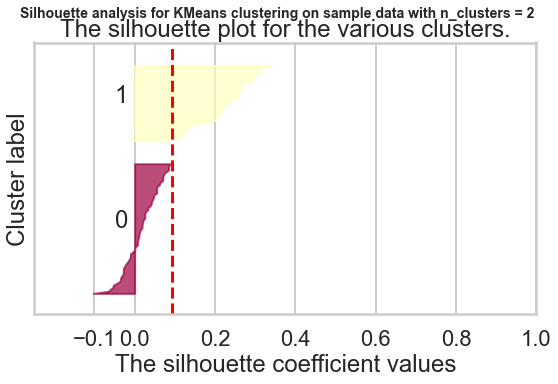

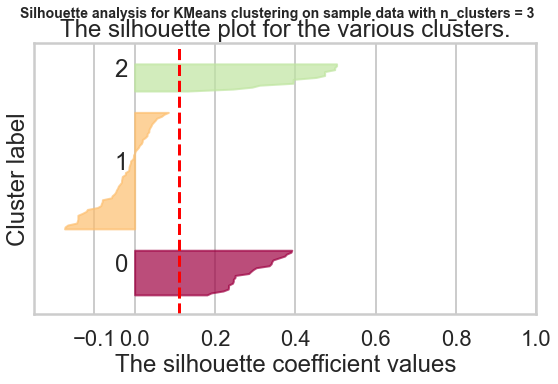

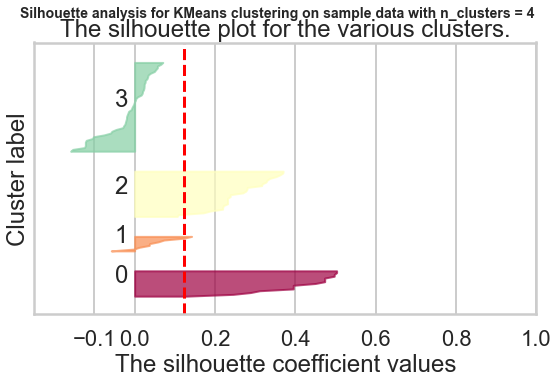

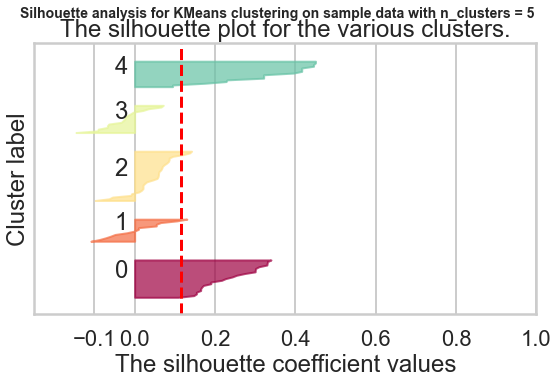

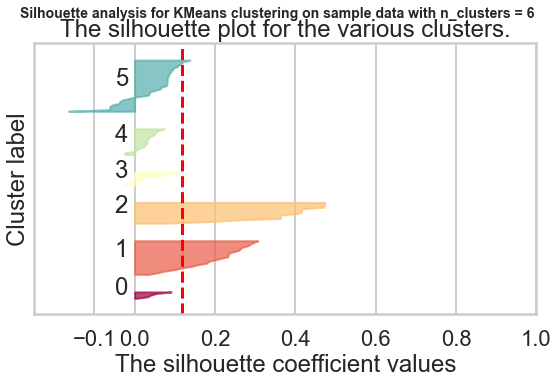

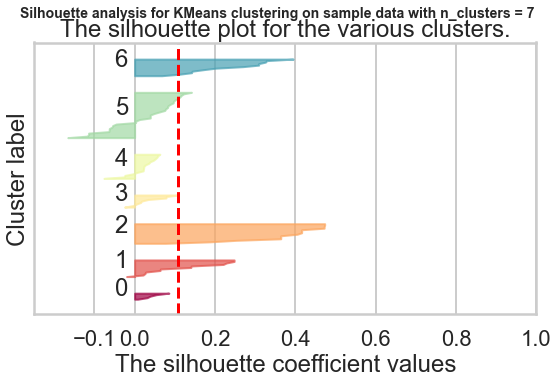

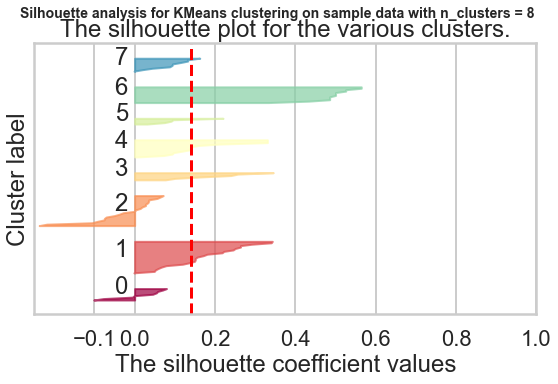

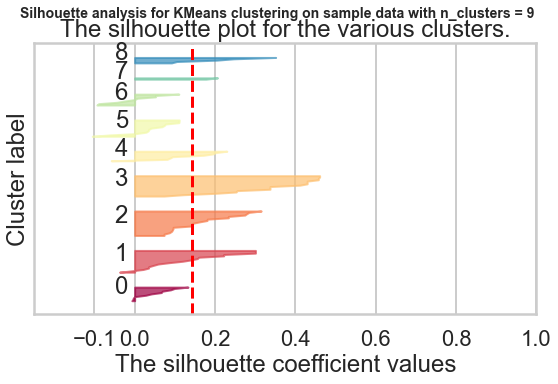

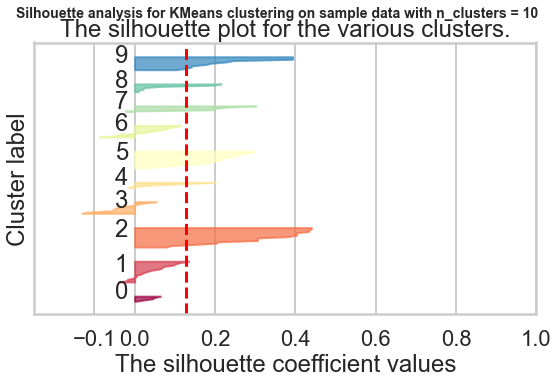

In [41]:
# Your turn.

# Borrowing from Tier 1:
# This is an exercise in adapting someone else's code for our own use; a very common practice for data scientists and programmers alike
# OUR SOURCE: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

import sklearn.metrics
import matplotlib.cm as cm

# Make an empty list called avg_silhouette_scores
avg_silhouette_scores = []

# Iterate through Krange with variable K as before
for K in Krange:
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(9, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    # Call set_xlim on ax1 
    ax1.set_xlim([-0.25, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (K + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = sklearn.cluster.KMeans(n_clusters=K, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    # Make a variable called silhouette_avg. Set the parameters to silhouette_score to X, and cluster_labels
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)
    avg_silhouette_scores.append(silhouette_avg)

    # Compute the silhouette scores for each sample
    # Call sklearn.metrics.silhouette_samples with the below parameters
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(K):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        # Make a variable called ith_cluster_silhouette_values
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        # Call sort() on this variable 
        ith_cluster_silhouette_values.sort()
    
        # Call shape[0] on ith_cluster_silhouette_values 
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / K)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        # This requires calling text() on ax1 
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    # Setting title, xlabel and ylabel 
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    # This requires axvline() 
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % K),
                 fontsize=14, fontweight='bold')

Text(0, 0.5, 'Average Silhouette Score')

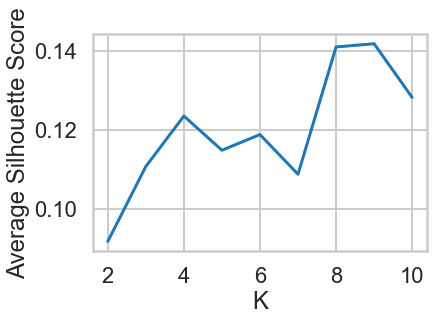

In [42]:
#Computing the average silhouette score for each K and plotting it 
# Call plot() with parameters KRange, avg_silhouette_scores
plt.plot(Krange, avg_silhouette_scores)
plt.xlabel("K")
plt.ylabel("Average Silhouette Score")

While the average silhouette score does improve at higher Ks, they're still very low averages. In fact, in K=8, there is only one cluster that seems to be >0.5, suggesting only one cluster in all of the clusters of all of the Ks is there a cluster of reasonable structure. Nevertheless, I think I would change from the K=4 I selected before to a K=8.

#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? By visual inspection on two dimensions, 3 clusters looks really good. 4 clusters seems to just split the biggest blob in the 3 cluster visualization, and any more than that seems to just be splitting more blobs. Granted, it's going to be difficult to make these higher dimension clusters look distinct on a 2-dimenional plane.
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually? I would look more into 4 and 8, but would start with the simpler 4 groups. Visually, however, 3 clusters looks great on a 2-dimensional PCA.
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
<p> Based on campaign, your cluster 0 customers are the year-round dependable customers. The other clusters also tend to buy year-round, but not as consistently as cluster 0.
<p><p> Based on varietal, there is definitely a story to be told. Cluster 0 is the champagne and cabernet sauvignon cluster. I would definitely recommend focus on them for campaigns inovling those two wines. Cluster 1, is the Pinot Grigio cluster. I would recommend focusing Pinto Grigio campaigns on them. Cluster 2 is almost exclusively (both within and among groups) Pinot Noir. I would recommend focusing Pinot Noir campaigns on those customers. Another two styles that pop out are Prosecco and Malbec - they are a common preference for the customers in clusters 0 and 1, so I would recommend ignoring cluster 2 customers for prosecco and malbec campaigns.
</div>

In [43]:
df_pivot.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Text(0, 0.5, 'y')

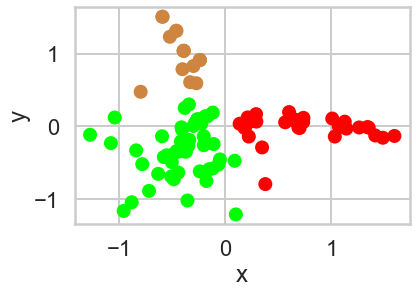

In [44]:
#your turn
import sklearn.decomposition
import matplotlib.colors

# Make a variable called model. We want n_clusters = 3 as parameter to sklearn.cluster.KMeans 
model = sklearn.cluster.KMeans(n_clusters=3)
# Call a fit_predict() on X 
cluster_assignments = model.fit_predict(X)

# Let's visualiaze with colors.ListedColormap
cmap = matplotlib.colors.ListedColormap(['red', 'green', 'blue','black','lime','orchid','dodgerblue','peru'])

# We're going to do some PCA here. Call decomposition.PCA on sklearn, and pass n_components=2 as parameter
pca = sklearn.decomposition.PCA(n_components=2)
pc1, pc2 = zip(*pca.fit_transform(X))
plt.scatter(pc1, pc2, c=cluster_assignments.tolist(), cmap=cmap)
plt.xlabel("x")
plt.ylabel("y")

In [96]:
# not sure if the order is preserved through the PCA process...
df_cluster_assignments = pd.DataFrame(cluster_assignments)
df_cluster_assignments.insert(0,'customer_name',df_pivot.index)
df_cluster_assignments.columns = ['customer_name','cluster_id']
df_cluster_assignments.head()

,customer_name,cluster_id
0,Adams,1
1,Allen,0
2,Anderson,2
3,Bailey,1
4,Baker,0


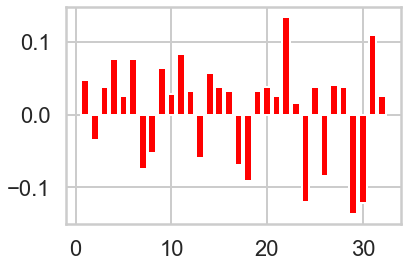

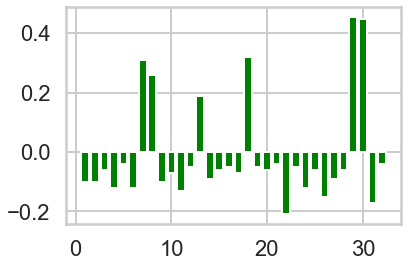

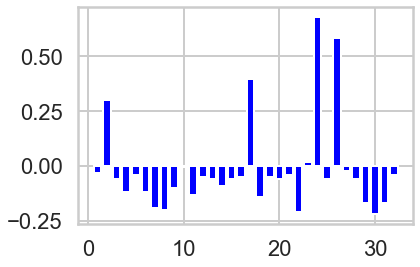

In [46]:
# Plot count of offer_id in each cluster.
# But, certain offers were used more than others in the original data.
# Let's compute the difference between how often they were used in each cluster vs globally.
model = sklearn.cluster.KMeans(n_clusters=3)
cluster_assignments = model.fit_predict(X)

colors = ['red', 'green', 'blue']
offer_proportions = df_pivot.sum(axis=0) / 100  # There are 100 customers
for i in range(3):
    plt.figure(i)
    cluster = df_pivot[cluster_assignments == i]
    offer_proportions_cluster = cluster.sum(axis=0) / cluster.shape[0]  # Number of customers in cluster
    lift = offer_proportions_cluster - offer_proportions
    plt.bar(range(1, 33), lift, color=colors[i])

In [104]:
df_cluster_assignments.merge(df_transactions).merge(df_offers)

,customer_name,cluster_id,offer_id,n,campaign,varietal,min_qty,discount,origin,past_peak
0,Adams,1,18,1,July,Espumante,6,50,Oregon,False
1,Gutierrez,0,18,1,July,Espumante,6,50,Oregon,False
2,Hill,1,18,1,July,Espumante,6,50,Oregon,False
3,James,1,18,1,July,Espumante,6,50,Oregon,False
4,King,1,18,1,July,Espumante,6,50,Oregon,False
...,...,...,...,...,...,...,...,...,...,...
319,Young,0,6,1,March,Prosecco,144,86,Chile,False
320,Powell,0,5,1,February,Cabernet Sauvignon,144,44,New Zealand,True
321,Reed,0,5,1,February,Cabernet Sauvignon,144,44,New Zealand,True
322,Sanchez,0,5,1,February,Cabernet Sauvignon,144,44,New Zealand,True


In [115]:
df_cluster_assignments.merge(df_transactions).merge(df_offers).groupby(['cluster_id', 'campaign']).describe()

offer_id                                                 \
                        count       mean       std   min    25%   50%    75%   
cluster_id campaign                                                            
0          April         16.0   9.375000  0.500000   9.0   9.00   9.0  10.00   
           August        31.0  21.483871  0.811212  20.0  21.00  22.0  22.00   
           December      27.0  30.925926  0.615563  30.0  31.00  31.0  31.00   
           February      22.0   3.909091  0.683763   3.0   3.25   4.0   4.00   
           January       13.0   1.307692  0.480384   1.0   1.00   1.0   2.00   
           July           8.0  18.625000  0.517549  18.0  18.00  19.0  19.00   
           June          20.0  14.800000  0.833509  14.0  14.00  15.0  15.25   
           March         28.0   6.892857  0.875142   6.0   6.00   7.0   8.00   
           May           18.0  11.277778  0.460889  11.0  11.00  11.0  11.75   
           November       8.0  28.250000  0.462910  28.0  28.00  28.0  28.25   
           October       18.0  26.111111  0.900254  25.0  25.00  26.0  27.00   
           September      4.0  23.000000  0.000000  23.0  23.00  23.0  23.00   
1          December      16.0  30.000000  0.000000  30.0  30.00  30.0  30.00   
           July          11.0  18.000000  0.000000  18.0  18.00  18.0  18.00   
           March         23.0   7.478261  0.510754   7.0   7.00   7.0   8.00   
           May            6.0  13.000000  0.000000  13.0  13.00  13.0  13.00   
           November      15.0  29.000000  0.000000  29.0  29.00  29.0  29.00   
2          April          1.0  10.000000       NaN  10.0  10.00  10.0  10.00   
           January        7.0   1.857143  0.377964   1.0   2.00   2.0   2.00   
           July           7.0  17.000000  0.000000  17.0  17.00  17.0  17.00   
           October       12.0  26.083333  0.288675  26.0  26.00  26.0  26.00   
           September     13.0  23.923077  0.277350  23.0  24.00  24.0  24.00   

                               n       ... min_qty        discount             \
                       max count mean  ...     75%    max    count       mean   
cluster_id campaign                    ...                                      
0          April      10.0  16.0  1.0  ...   144.0  144.0     16.0  55.125000   
           August     22.0  31.0  1.0  ...    72.0   72.0     31.0  65.000000   
           December   32.0  27.0  1.0  ...    72.0   72.0     27.0  74.703704   
           February    5.0  22.0  1.0  ...   144.0  144.0     22.0  42.909091   
           January     2.0  13.0  1.0  ...    72.0   72.0     13.0  44.000000   
           July       19.0   8.0  1.0  ...    12.0   12.0      8.0  60.000000   
           June       16.0  20.0  1.0  ...   144.0  144.0     20.0  56.500000   
           March       8.0  28.0  1.0  ...   144.0  144.0     28.0  61.321429   
           May        12.0  18.0  1.0  ...    72.0   72.0     18.0  84.444444   
           November   29.0   8.0  1.0  ...    12.0   12.0      8.0  63.750000   
           October    27.0  18.0  1.0  ...    72.0  144.0     18.0  77.222222   
           September  23.0   4.0  1.0  ...   144.0  144.0      4.0  39.000000   
1          December   30.0  16.0  1.0  ...     6.0    6.0     16.0  54.000000   
           July       18.0  11.0  1.0  ...     6.0    6.0     11.0  50.000000   
           March       8.0  23.0  1.0  ...     6.0    6.0     23.0  42.391304   
           May        13.0   6.0  1.0  ...     6.0    6.0      6.0  43.000000   
           November   29.0  15.0  1.0  ...     6.0    6.0     15.0  87.000000   
2          April      10.0   1.0  1.0  ...    72.0   72.0      1.0  52.000000   
           January     2.0   7.0  1.0  ...    72.0   72.0      7.0  22.571429   
           July       17.0   7.0  1.0  ...    12.0   12.0      7.0  47.000000   
           October    27.0  12.0  1.0  ...   144.0  144.0     12.0  83.416667   
           September  24.0  13.0  1.0  ...     6.0  144.0     13.0  34.38461

In [117]:
df_cluster_assignments.merge(df_transactions).merge(df_offers).groupby(['cluster_id', 'varietal']).describe()

offer_id                                    \
                                 count       mean        std   min   25%   
cluster_id varietal                                                        
0          Cabernet Sauvignon     32.0  21.125000   8.268674   5.0  15.0   
           Champagne              80.0  19.687500   9.181150   4.0  11.0   
           Chardonnay             14.0  13.000000   6.563301   9.0   9.0   
           Espumante              18.0   8.000000   5.144958   3.0   3.0   
           Malbec                 15.0  12.600000  14.705684   1.0   1.0   
           Merlot                 14.0  14.714286   0.994490  14.0  14.0   
           Pinot Grigio            2.0  29.000000   0.000000  29.0  29.0   
           Pinot Noir              8.0  14.000000  12.828540   2.0   2.0   
           Prosecco               30.0   8.033333   2.341284   6.0   6.0   
1          Espumante              22.0  13.000000   5.117663   8.0   8.0   
           Malbec                 16.0  30.000000   0.000000  30.0  30.0   
           Merlot                  6.0  13.000000   0.000000  13.0  13.0   
           Pinot Grigio           15.0  29.000000   0.000000  29.0  29.0   
           Prosecco               12.0   7.000000   0.000000   7.0   7.0   
2          Champagne               1.0  27.000000        NaN  27.0  27.0   
           Chardonnay              1.0  23.000000        NaN  23.0  23.0   
           Malbec                  1.0   1.000000        NaN   1.0   1.0   
           Pinot Noir             36.0  19.583333   8.600249   2.0  17.0   
           Prosecco                1.0  10.000000        NaN  10.0  10.0   

                                                    n       ... min_qty  \
                                50%   75%   max count mean  ...     75%   
cluster_id varietal                                         ...           
0          Cabernet Sauvignon  22.5  28.0  32.0  32.0  1.0  ...   144.0   
           Champagne           22.0  27.0  31.0  80.0  1.0  ...    72.0   
           Chardonnay           9.0  19.5  23.0  14.0  1.0  ...   144.0   
           Espumante            8.0   8.0  18.0  18.0  1.0  ...   144.0   
           Malbec               1.0  30.0  30.0  15.0  1.0  ...    72.0   
           Merlot              14.0  16.0  16.0  14.0  1.0  ...    72.0   
           Pinot Grigio        29.0  29.0  29.0   2.0  1.0  ...     6.0   
           Pinot Noir          14.0  26.0  26.0   8.0  1.0  ...   144.0   
           Prosecco             7.0  10.0  12.0  30.0  1.0  ...   144.0   
1          Espumante           13.0  18.0  18.0  22.0  1.0  ...     6.0   
           Malbec              30.0  30.0  30.0  16.0  1.0  ...     6.0   
           Merlot              13.0  13.0  13.0   6.0  1.0  ...     6.0   
           Pinot Grigio        29.0  29.0  29.0  15.0  1.0  ...     6.0   
           Prosecco             7.0   7.0   7.0  12.0  1.0  ...     6.0   
2          Champagne           27.0  27.0  27.0   1.0  1.0  ...    72.0   
           Chardonnay          23.0  23.0  23.0   1.0  1.0  ...   144.0   
           Malbec               1.0   1.0   1.0   1.0  1.0  ...    72.0   
           Pinot Noir          24.0  26.0  26.0  36.0  1.0  ...   144.0   
           Prosecco            10.0  10.0  10.0   1.0  1.0  ...    72.0   

                                     discount                              \
                                 max    count       mean        std   min   
cluster_id varietal                                                         
0          Cabernet Sauvignon  144.0     32.0  51.625000  20.297386  19.0   
           Champagne            72.0     80.0  71.887500  15.865729  48.0   
           Chardonnay          144.0     14.0  51.857143   8.438530  39.0   
           Espumante           144.0     18.0  41.500000   7.147603  32.0   
           Malbec               72.0     15.0  55.200000   1.014185  54.0   
           Merlot               72.0     14.0  72.571429  11.933884  64.0   
           Pi

In [116]:
df_cluster_assignments.merge(df_transactions).merge(df_offers).groupby(['cluster_id', 'origin']).describe()

offer_id                                          \
                           count       mean        std   min   25%   50%   
cluster_id origin                                                          
0          Australia        16.0  13.312500   7.880091   7.0   7.0  12.0   
           California       15.0  14.933333   4.620864  10.0  10.0  16.0   
           Chile            31.0   9.290323   3.318569   6.0   6.0   9.0   
           France           90.0  17.811111  11.379949   1.0   4.0  22.0   
           Germany           9.0  24.777778   6.851602  19.0  19.0  19.0   
           Italy            12.0  17.500000   2.611165  15.0  15.0  17.5   
           New Zealand      12.0  19.666667  10.832051   5.0   5.0  27.0   
           Oregon           15.0  14.800000  10.317807   3.0   3.0  18.0   
           South Africa     13.0  12.615385   7.205767   8.0   8.0   8.0   
1          Australia        12.0   7.000000   0.000000   7.0   7.0   7.0   
           Chile             6.0  13.000000   0.000000  13.0  13.0  13.0   
           France           31.0  29.516129   0.508001  29.0  29.0  30.0   
           Oregon           11.0  18.000000   0.000000  18.0  18.0  18.0   
           South Africa     11.0   8.000000   0.000000   8.0   8.0   8.0   
2          Australia        11.0  26.000000   0.000000  26.0  26.0  26.0   
           California        1.0  10.000000        NaN  10.0  10.0  10.0   
           France            7.0   1.857143   0.377964   1.0   2.0   2.0   
           Germany           7.0  17.000000   0.000000  17.0  17.0  17.0   
           Italy            12.0  24.000000   0.000000  24.0  24.0  24.0   
           New Zealand       1.0  27.000000        NaN  27.0  27.0  27.0   
           South Africa      1.0  23.000000        NaN  23.0  23.0  23.0   

                                         n       ... min_qty        discount  \
                           75%   max count mean  ...     75%    max    count   
cluster_id origin                                ...                           
0          Australia     15.50  26.0  16.0  1.0  ...    90.0  144.0     16.0   
           California    18.50  21.0  15.0  1.0  ...    72.0   72.0     15.0   
           Chile         14.00  14.0  31.0  1.0  ...   144.0  144.0     31.0   
           France        29.75  31.0  90.0  1.0  ...    72.0   72.0     90.0   
           Germany       32.00  32.0   9.0  1.0  ...    72.0   72.0      9.0   
           Italy         20.00  20.0  12.0  1.0  ...   144.0  144.0     12.0   
           New Zealand   27.00  27.0  12.0  1.0  ...   144.0  144.0     12.0   
           Oregon        25.00  25.0  15.0  1.0  ...   144.0  144.0     15.0   
           South Africa  23.00  23.0  13.0  1.0  ...   144.0  144.0     13.0   
1          Australia      7.00   7.0  12.0  1.0  ...     6.0    6.0     12.0   
           Chile         13.00  13.0   6.0  1.0  ...     6.0    6.0      6.0   
           France        30.00  30.0  31.0  1.0  ...     6.0    6.0     31.0   
           Oregon        18.00  18.0  11.0  1.0  ...     6.0    6.0     11.0   
           South Africa   8.00   8.0  11.0  1.0  ...     6.0    6.0     11.0   
2          Australia     26.00  26.0  11.0  1.0  ...   144.0  144.0     11.0   
           California    10.00  10.0   1.0  1.0  ...    72.0   72.0      1.0   
           France         2.00   2.0   7.0  1.0  ...    72.0   72.0      7.0   
           Germany       17.00  17.0   7.0  1.0  ...    12.0   12.0      7.0   
           Italy         24.00  24.0  12.0  1.0  ...     6.0    6.0     12.0   
           New Zealand   27.00  27.0   1.0  1.0  ...    72.0   72.0      1.0   
           South Africa  23.00  23.0   1.0  1.0  ...   144.0  144.0      1.0   

                                                                             
                              mean        std   min   25%   50%   75%   max  
cluster_id origin                                                            
0          Australia     64.187500  22.03094

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

Text(0, 0.5, 'Proportion of Variance Explained')

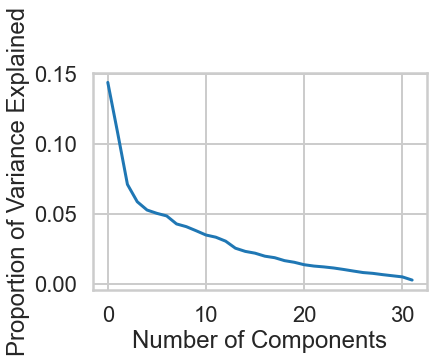

In [47]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(X)

# Call fit() on pca, with X passed to the method
pca.fit(X)

# Let's finish this :)  Make a variable called variance
variance = pca.explained_variance_ratio_

# Plot() it 
plt.plot(range(len(variance)), variance)

# Label the axes
plt.xlabel("Number of Components")
plt.ylabel("Proportion of Variance Explained")


## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call. 

### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
<p>Affinity propagation suggests 10 clusters, which is higher than anything seen so far. Given its use case is for many clusters, this is probably not the best application for it.</p>
<p>DBSCAN suggets 6 clusters, which is more in line with what has been seen. Further, the visualization makes sense. However, there's no real evidence from the prior work that 6 clusters is any better of a generalization than 4 clusters.</p>
<p>Both spectral clustering and agglomerative clustering were provided K=4 as an input and look good visually. However, given that the use case for agglomerative clustering is for many clusters and the use case for spectral clustering is few clusters, I would put spectral clustering as the best performer for this application. Further, the more even cluster size would allow for more generalized analysis of the customer behavior of each cluster on its own.
</div>


In [58]:
from sklearn.cluster import AffinityPropagation, SpectralClustering, AgglomerativeClustering, DBSCAN
from sklearn import metrics
import matplotlib.pyplot as plt
from numpy import random

In [59]:
#Code for PCA: https://nickmccullum.com/python-machine-learning/principal-component-analysis-python/
#Affinity Propagation, Specteral Clustering, Agglomerative Clustering, and DBSCAN requrie PCA to transform the X matrix into an (X,2) shape matrix.
pca = sklearn.decomposition.PCA(n_components=2)
pca.fit(X)
Xpca = pca.transform(X)


Text(0.5, 1.0, 'Estimated number of clusters:  10')

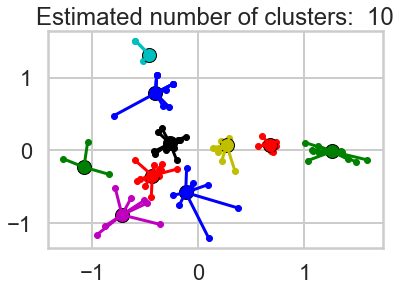

In [60]:
# Code source: https://www.geeksforgeeks.org/affinity-propagation-in-ml-to-find-the-number-of-clusters/
# Compute Affinity Propagation
af = AffinityPropagation(random_state=None).fit(Xpca)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

# Plot result
import matplotlib.pyplot as plt
from itertools import cycle
  
plt.close('all')
plt.figure(1)
plt.clf()
  
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
  
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = Xpca[cluster_centers_indices[k]]
    plt.plot(Xpca[class_members, 0], Xpca[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o',
             markerfacecolor = col, markeredgecolor ='k',
             markersize = 14)
  
    for x in Xpca[class_members]:
        plt.plot([cluster_center[0], x[0]], 
                 [cluster_center[1], x[1]], col)
  
plt.title('Estimated number of clusters: % d' % n_clusters_)

SpectralClustering(n_clusters=4)


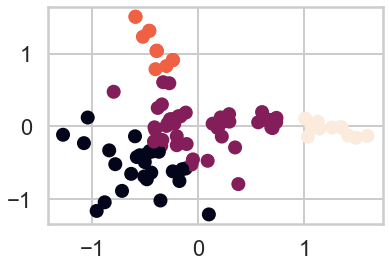

In [61]:
# Code source for Spectral Clustering: https://www.datatechnotes.com/2020/12/spectral-clustering-example-in-python.html

sc = SpectralClustering(n_clusters=4).fit(Xpca)
print(sc)
 
SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver=None, eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=4, n_components=None,
                   n_init=10, n_jobs=None, n_neighbors=10, random_state=None) 

labels = sc.labels_

plt.scatter(Xpca[:,0],Xpca[:,1], c=labels)
plt.show()

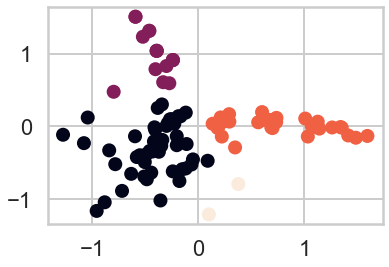

In [62]:
# Code source for Agglomerative Clustering: https://machinelearninggeek.com/agglomerative-clustering/

agg_model = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='average')
agg_model.fit(Xpca)
cluster_label = agg_model.labels_
clusters = pd.DataFrame(agg_model.fit_predict(Xpca))
plt.scatter(Xpca[:,0],Xpca[:,1], c=cluster_label)

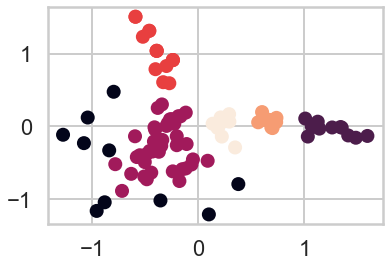

In [86]:
# Code source for DBScan: https://www.machinecurve.com/index.php/2020/12/09/performing-dbscan-clustering-with-python-and-scikit-learn/
# epsilon - The maximum distance between two samples for one to be considered as in the neighborhood of the other. 
epsilon = .25

db = DBSCAN(eps=epsilon).fit(Xpca)
labels = db.labels_
plt.scatter(Xpca[:,0],Xpca[:,1], c=labels)

In [87]:
no_clusters = len(np.unique(labels) )
no_noise = np.sum(np.array(labels) == -1, axis=0)

print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Estimated no. of clusters: 6
Estimated no. of noise points: 10
